In [1]:
import json
import pickle
import re
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd
import torch
from scipy.stats import semicircular, gaussian_kde
from sklearn.manifold import TSNE
import umap

In [2]:
def schatten_norm(data, p=1):
    _, s, _ = svd(data.reshape(1, -1), full_matrices=False)
    return np.sum(s**p)**(1/p)

def explained_variance_ratio(data):
    _, s, _ = svd(data, full_matrices=False)
    variance_ratio = (s**2) / np.sum(s**2)
    cumulative_variance_ratio = np.cumsum(variance_ratio)
    return variance_ratio, cumulative_variance_ratio

def plot_activation_difference_variance(baseline_diffs, at_diffs, lat_diffs, n_components=10):
    baseline_var, baseline_cum_var = explained_variance_ratio(baseline_diffs)
    at_var, at_cum_var = explained_variance_ratio(at_diffs)
    lat_var, lat_cum_var = explained_variance_ratio(lat_diffs)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Bar plot
    x = np.arange(n_components)
    width = 0.25
    
    ax1.bar(x - width, baseline_var[:n_components], width, color='tab:blue', label='Baseline Model', alpha=0.7)
    ax1.bar(x, at_var[:n_components], width, label='AT Model', color='tab:orange', alpha=0.7)
    ax1.bar(x + width, lat_var[:n_components], width, label='LAT Model', color='tab:red', alpha=0.7)
    
    ax1.set_xlabel('SVD Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Explained Variance of Activation Differences by SVD Component')
    ax1.set_xticks(x)
    ax1.set_xticklabels(range(1, n_components+1))
    ax1.legend()
    
    # Line plot
    ax2.plot(range(1, n_components+1), baseline_cum_var[:n_components], 'o-', color="tab:blue", label='Baseline Model')
    ax2.plot(range(1, n_components+1), at_cum_var[:n_components], 'o-', color="tab:orange", label='AT Model')
    ax2.plot(range(1, n_components+1), lat_cum_var[:n_components], 'o-', color="tab:red", label='LAT Model')
    ax2.set_xlabel('Number of SVD Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance of Activation Differences')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Explained variance at SVD component 1:")
    print(f"Baseline Model: {baseline_var[0]:.4f}")
    print(f"AT Model: {at_var[0]:.4f}")
    print(f"LAT Model: {lat_var[0]:.4f}")

    # Calculate total variance explained by top 10 components
    total_var_baseline = np.sum(baseline_var[:n_components])
    total_var_at = np.sum(at_var[:n_components])
    total_var_lat = np.sum(lat_var[:n_components])

    print(f"\nTotal variance explained by top {n_components} components:")
    print(f"Baseline Model: {total_var_baseline:.4f}")
    print(f"AT Model: {total_var_at:.4f}")
    print(f"LAT Model: {total_var_lat:.4f}")

In [3]:
with open('../data_store/results_layers_base_np.pkl', 'rb') as fr:
    base_results = pickle.load(fr)

with open('../data_store/results_layers_lat_np.pkl', 'rb') as fr:
    lat_results = pickle.load(fr)

with open('../data_store/results_layers_at_np.pkl', 'rb') as fr:
    at_results = pickle.load(fr)

In [4]:
base_results_best_layer = base_results[13]
print(base_results_best_layer['run_id'])
base_harmful_acts = torch.tensor(base_results_best_layer['harmful_acts'])
base_harmless_acts = torch.tensor(base_results_best_layer['harmless_acts'])
base_norm_refusal_dir = torch.tensor(base_results_best_layer['refusal_dir'])
base_unnorm_refusal_dir = (base_harmful_acts.mean(dim=0) - base_harmless_acts.mean(dim=0))

base_diffs = base_harmful_acts - base_harmless_acts

base_n_samples_416.layer_14


In [5]:
at_results_best_layer = at_results[13]
print(at_results_best_layer['run_id'])
at_harmful_acts = torch.tensor(at_results_best_layer['harmful_acts'])
at_harmless_acts = torch.tensor(at_results_best_layer['harmless_acts'])
at_norm_refusal_dir = torch.tensor(at_results_best_layer['refusal_dir'])
at_unnorm_refusal_dir = (at_harmful_acts.mean(dim=0) - at_harmless_acts.mean(dim=0))

at_diffs = at_harmful_acts - at_harmless_acts

at_n_samples_416.layer_14


In [6]:
lat_results_best_layer = lat_results[13]
print(lat_results_best_layer['run_id'])
lat_harmful_acts = torch.tensor(lat_results_best_layer['harmful_acts'])
lat_harmless_acts = torch.tensor(lat_results_best_layer['harmless_acts'])
lat_norm_refusal_dir = torch.tensor(lat_results_best_layer['refusal_dir'])
lat_unnorm_refusal_dir = (lat_harmful_acts.mean(dim=0) - lat_harmless_acts.mean(dim=0)).cpu()

lat_diffs = lat_harmful_acts - lat_harmless_acts

lat_n_samples_416.layer_14


In [7]:
base_diffs_norm = base_diffs / base_diffs.norm(keepdim=True, dim=-1)
at_diffs_norm = at_diffs / at_diffs.norm(keepdim=True, dim=-1)
lat_diffs_norm = lat_diffs / lat_diffs.norm(keepdim=True, dim=-1)

In [12]:
print("Activation Differences (unnormalised)")
print(f"[BASE] Schatten norm (p=1): {schatten_norm(base_diffs):.4f}")
print(f"[AT]   Schatten norm (p=1): {schatten_norm(at_diffs):.4f}")
print(f"[LAT]  Schatten norm (p=1): {schatten_norm(lat_diffs):.4f}")

print()

print("Activation Differences (normalised)")
print(f"[BASE] Schatten norm (p=1): {schatten_norm(base_diffs_norm):.4f}")
print(f"[AT]   Schatten norm (p=1): {schatten_norm(at_diffs_norm):.4f}")
print(f"[LAT]  Schatten norm (p=1): {schatten_norm(lat_diffs_norm):.4f}")

Activation Differences (unnormalised)
[BASE] Schatten norm (p=1): 376.1108
[AT]   Schatten norm (p=1): 353.0620
[LAT]  Schatten norm (p=1): 521.0562

Activation Differences (normalised)
[BASE] Schatten norm (p=1): 20.3960
[AT]   Schatten norm (p=1): 20.3961
[LAT]  Schatten norm (p=1): 20.3960


In [9]:
print("Normalised Refusal Vector")
print(f"[BASE] Schatten norm (p=1): {schatten_norm(base_norm_refusal_dir):.4f}")
print(f"[AT]   Schatten norm (p=1): {schatten_norm(at_norm_refusal_dir):.4f}")
print(f"[LAT]  Schatten norm (p=1): {schatten_norm(lat_norm_refusal_dir):.4f}")

print()

print("Unnoormalised Refusal Vector")
print(f"[BASE] Schatten norm (p=1): {schatten_norm(base_unnorm_refusal_dir):.4f}")
print(f"[AT]   Schatten norm (p=1): {schatten_norm(at_unnorm_refusal_dir):.4f}")
print(f"[LAT]  Schatten norm (p=1): {schatten_norm(lat_unnorm_refusal_dir):.4f}")

Normalised Refusal Vector
[BASE] Schatten norm (p=1): 0.9999
[AT]   Schatten norm (p=1): 1.0000
[LAT]  Schatten norm (p=1): 1.0001

Unnoormalised Refusal Vector
[BASE] Schatten norm (p=1): 12.7403
[AT]   Schatten norm (p=1): 11.2264
[LAT]  Schatten norm (p=1): 11.5321


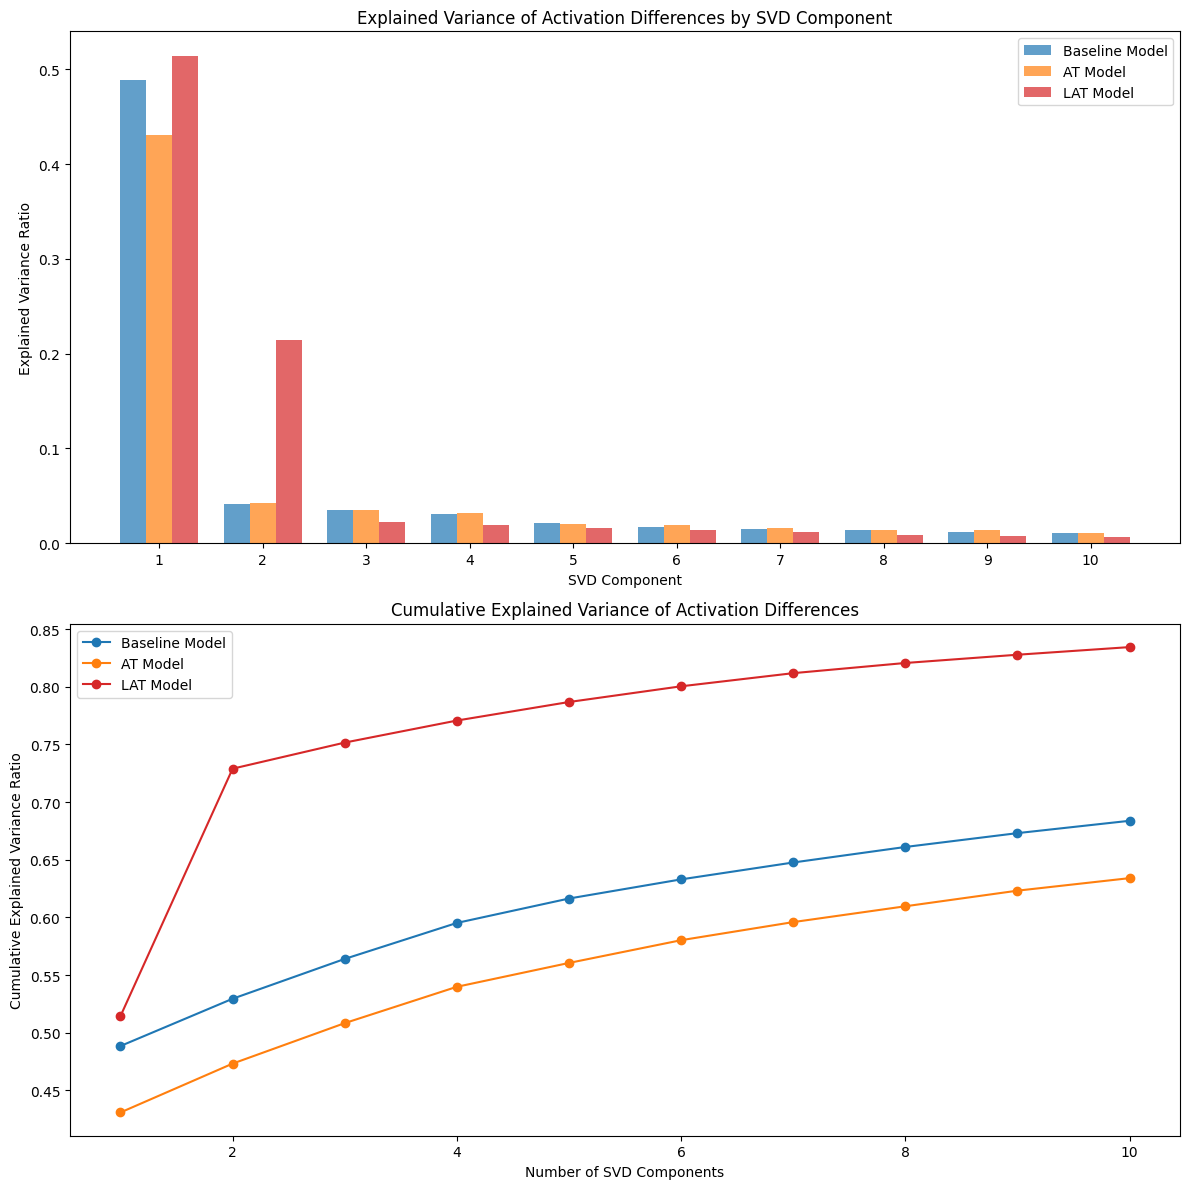

Explained variance at SVD component 1:
Baseline Model: 0.4885
AT Model: 0.4309
LAT Model: 0.5144

Total variance explained by top 10 components:
Baseline Model: 0.6837
AT Model: 0.6340
LAT Model: 0.8343


In [31]:
plot_activation_difference_variance(base_diffs, at_diffs, lat_diffs)

In [31]:
def singular_value_distribution(data):
    _, s, _ = svd(data, full_matrices=False)
    return s / np.sqrt(np.sum(s**2))

def wigner_semicircle(x, R):
    return np.sqrt(R**2 - x**2) / (np.pi * R**2)

def marchenko_pastur(x, y):
    lambda_plus = (1 + np.sqrt(y))**2
    lambda_minus = (1 - np.sqrt(y))**2
    return np.sqrt((lambda_plus - x) * (x - lambda_minus)) / (2 * np.pi * y * x)

def create_noisy_copies(vector, n_copies, noise_level):
    return vector + noise_level * np.random.randn(n_copies, len(vector))

def plot_distributions(actual_sv, noisy_sv, n, p, model_type):
    plt.figure(figsize=(12, 6))
    
    # Actual data
    kde = gaussian_kde(actual_sv)
    x_range = np.linspace(0, max(actual_sv), 1000)
    plt.plot(x_range, kde(x_range), label='Actual Data')
    
    # Noisy copies
    kde_noisy = gaussian_kde(noisy_sv)
    plt.plot(x_range, kde_noisy(x_range), label='Noisy Copies')
    
    # Wigner's semicircle
    R = np.sqrt(2)  # For normalized singular values
    plt.plot(x_range, wigner_semicircle(x_range, R), label="Wigner's Semicircle")
    
    # Marchenko-Pastur
    y = n / p
    valid_range = x_range[(x_range >= (1 - np.sqrt(y))**2) & (x_range <= (1 + np.sqrt(y))**2)]
    plt.plot(valid_range, marchenko_pastur(valid_range, y), label='Marchenko-Pastur')
    
    plt.xlabel('Normalized Singular Values')
    plt.ylabel('Density')
    plt.title(f'[{model_type}] Singular Value Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

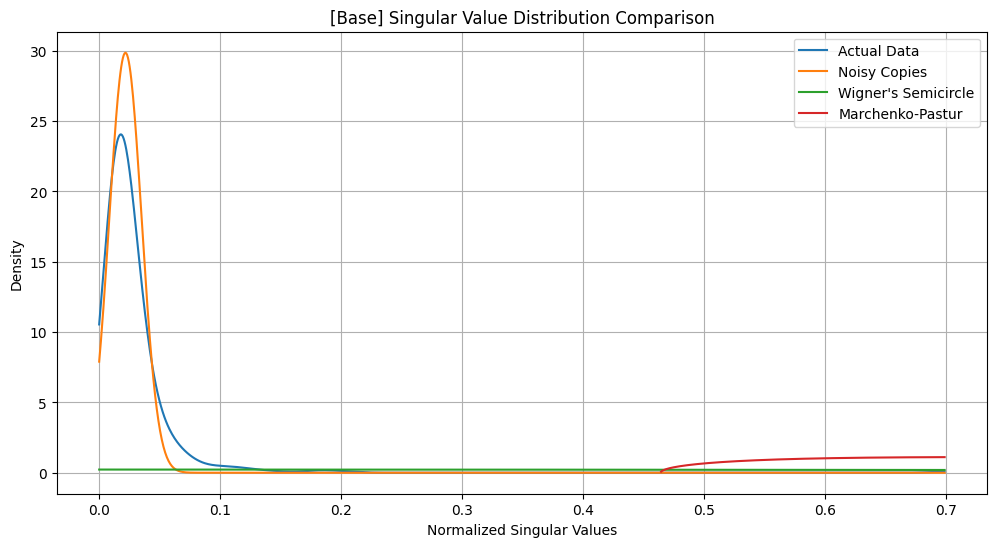

In [32]:
actual_sv = singular_value_distribution(base_diffs)

noisy_copies = create_noisy_copies(base_unnorm_refusal_dir, base_diffs.shape[0], 0.1)
noisy_sv = singular_value_distribution(noisy_copies)

# Plot distributions
n, p = base_diffs.shape
plot_distributions(actual_sv, noisy_sv, n, p, model_type='Base')

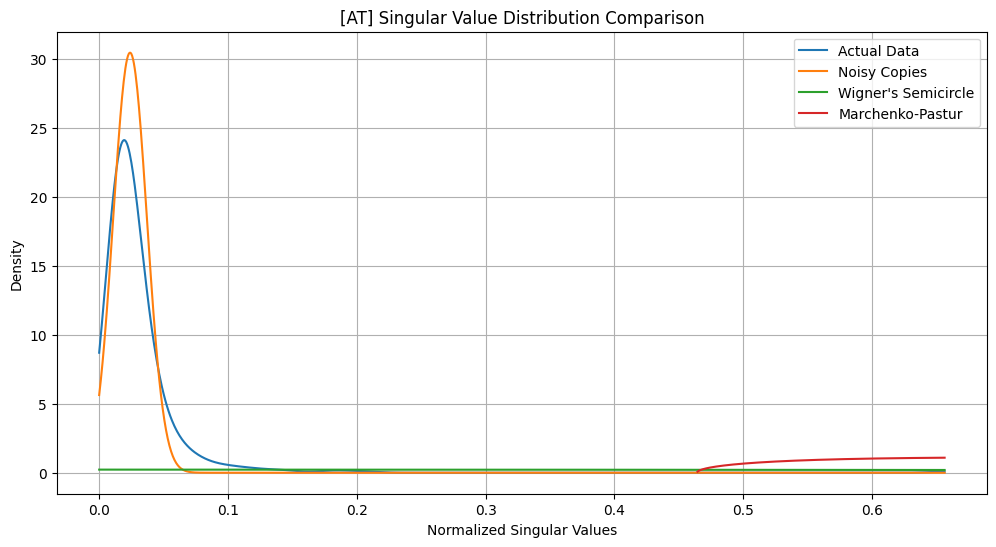

In [33]:
actual_sv = singular_value_distribution(at_diffs)

noisy_copies = create_noisy_copies(at_unnorm_refusal_dir, at_diffs.shape[0], 0.1)
noisy_sv = singular_value_distribution(noisy_copies)

# Plot distributions
n, p = at_diffs.shape
plot_distributions(actual_sv, noisy_sv, n, p, 'AT')

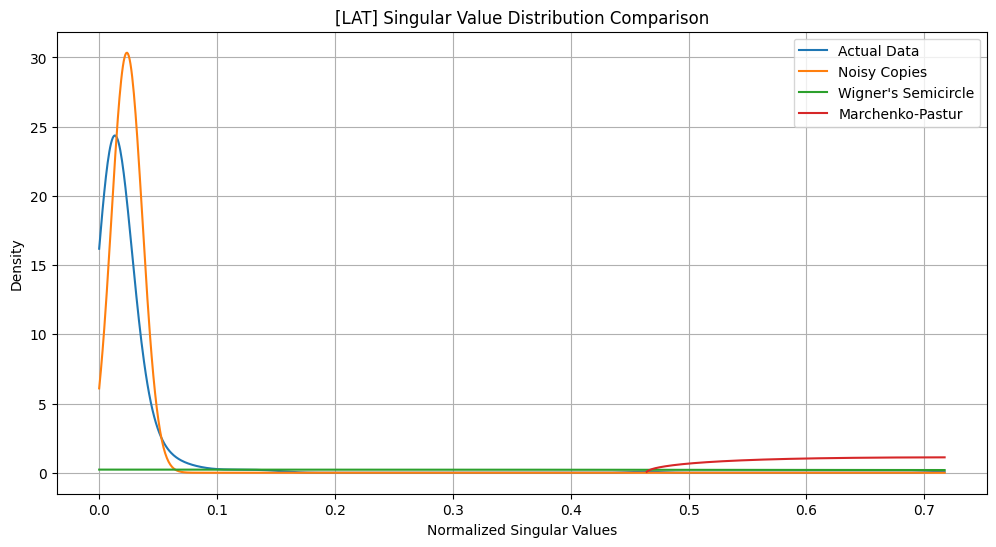

In [34]:
actual_sv = singular_value_distribution(lat_diffs)

noisy_copies = create_noisy_copies(lat_unnorm_refusal_dir, lat_diffs.shape[0], 0.1)
noisy_sv = singular_value_distribution(noisy_copies)

# Plot distributions
n, p = lat_diffs.shape
plot_distributions(actual_sv, noisy_sv, n, p, 'LAT')

### 2d projections of activations

In [60]:
from sklearn.decomposition import PCA

In [130]:
# def visualize_activations_pca_multi_layer(results, layers, model_type):
#     fig, axs = plt.subplots(len(layers) // 2, 2, figsize=(20, 40))
#     axs = axs.flatten()

#     for idx, layer in enumerate(layers):
#         harmless_acts = results[layer - 1]['harmless_acts']
#         harmful_acts = results[layer - 1]['harmful_acts']

#         # combine & apply PCA
#         all_activations = np.concatenate([harmful_acts, harmless_acts], axis=0)
#         pca = PCA(n_components=2)
#         projected_activations = pca.fit_transform(all_activations)

#         n = harmless_acts.shape[0]
#         harmless_proj = projected_activations[:n]
#         harmful_proj = projected_activations[n:2*n]

#         # plot on the corresponding subplot
#         axs[idx].scatter(harmless_proj[:, 0], harmless_proj[:, 1], color='tab:green', label='Harmless', alpha=0.7)
#         axs[idx].scatter(harmful_proj[:, 0], harmful_proj[:, 1], color='tab:red', label='Harmful', alpha=0.7)

#         refusal_rate = results[layer - 1]['refusal_rate']
#         axs[idx].set_title(f"PCA of Activations at Layer {layer}. Refusal Rate: {refusal_rate:.2f}%", fontsize=18)
#         axs[idx].set_xlabel("PC 1", fontsize=14)
#         axs[idx].set_ylabel("PC 2", fontsize=14)

#         axs[idx].legend()

#     model_s = 'base model'
    
#     if model_type == 'at':
#         model_s += ' + AT adapter'
#     elif model_type == 'lat':
#         model_s += ' + LAT adapter'
    
#     fig.suptitle(f"\nPCA of Activations of {model_s}\n\n\n", fontsize=24)
#     plt.tight_layout()

#     plt.savefig(f"activations_pca_multi_layer_{model_type}.png")

#     plt.show()
#     plt.close()

In [182]:
# def visualize_refusal_directions_pca_multi_layer(results, layers, model_type):
#     fig, axs = plt.subplots(len(layers) // 2, 2, figsize=(20, 40))
#     axs = axs.flatten()

#     for idx, layer in enumerate(layers):
#         harmless_acts = results[layer - 1]['harmless_acts']
#         harmful_acts = results[layer - 1]['harmful_acts']

#         refusal_dirs = harmful_acts - harmless_acts
#         pca = PCA(n_components=2)
#         projected_activations = pca.fit_transform(refusal_dirs)

#         # plot on the corresponding subplot
#         axs[idx].scatter(projected_activations[:, 0], projected_activations[:, 1], color='tab:blue', alpha=0.7)

#         refusal_rate = results[layer - 1]['refusal_rate']
#         axs[idx].set_title(f"PCA of Refusal Directions at Layer {layer}. Refusal Rate: {refusal_rate:.2f}%", fontsize=18)
#         axs[idx].set_xlabel("PC 1", fontsize=14)
#         axs[idx].set_ylabel("PC 2", fontsize=14)

#     model_s = 'base model'
    
#     if model_type == 'at':
#         model_s += ' + AT adapter'
#     elif model_type == 'lat':
#         model_s += ' + LAT adapter'
    
#     fig.suptitle(f"\nRefusal Directions PCA of {model_s}\n\n\n", fontsize=24)
#     plt.tight_layout()

#     plt.savefig(f"refusal_directions_pca_multi_layer_{model_type}.png")

#     plt.show()
#     plt.close()

In [184]:
def visualize_activations_multi_technique(results, layers, model_type, technique='pca'):
    fig, axs = plt.subplots(len(layers) // 2, 2, figsize=(20, 40))
    axs = axs.flatten()

    for idx, layer in enumerate(layers):
        harmless_acts = results[layer - 1]['harmless_acts']
        harmful_acts = results[layer - 1]['harmful_acts']

        # combine activations
        all_activations = np.concatenate([harmful_acts, harmless_acts], axis=0)

        # apply dimensionality reduction
        if technique.lower() == 'pca':
            reducer = PCA(n_components=2)
            projected_activations = reducer.fit_transform(all_activations)
        elif technique.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42)
            projected_activations = reducer.fit_transform(all_activations)
        elif technique.lower() == 'umap':
            reducer = umap.UMAP(n_components=2)
            projected_activations = reducer.fit_transform(all_activations)
        else:
            raise ValueError("Invalid technique. Choose 'pca', 'tsne', or 'umap'.")

        n = harmless_acts.shape[0]
        harmless_proj = projected_activations[:n]
        harmful_proj = projected_activations[n:2*n]

        # plot on the corresponding subplot
        axs[idx].scatter(harmless_proj[:, 0], harmless_proj[:, 1], color='tab:green', label='Harmless', alpha=0.7)
        axs[idx].scatter(harmful_proj[:, 0], harmful_proj[:, 1], color='tab:red', label='Harmful', alpha=0.7)

        refusal_rate = results[layer - 1]['refusal_rate']
        axs[idx].set_title(f"{technique.upper()} of Activations at Layer {layer}. Refusal Rate: {refusal_rate:.2f}%", fontsize=18)
        axs[idx].set_xlabel(f"{technique.upper()} 1", fontsize=14)
        axs[idx].set_ylabel(f"{technique.upper()} 2", fontsize=14)

        axs[idx].legend()

    model_s = 'base model'
    
    if model_type == 'at':
        model_s += ' + AT adapter'
    elif model_type == 'lat':
        model_s += ' + LAT adapter'
    
    fig.suptitle(f"\n{technique.upper()} of Activations of {model_s}\n\n\n", fontsize=24)
    plt.tight_layout()

    plt.savefig(f"activations_{technique.lower()}_multi_layer_{model_type}.png")

    plt.show()
    plt.close()

In [194]:
# visualize_activations_multi_technique(base_results, range(1, 21), model_type='base', technique='umap')
# visualize_activations_multi_technique(at_results, range(1, 21), model_type='at', technique='umap')
# visualize_activations_multi_technique(lat_results, range(1, 21), model_type='lat', technique='umap')

In [195]:
def visualize_refusal_directions_combined_multi_technique(base_results, at_results, lat_results, layers, technique='pca'):
    fig, axs = plt.subplots(len(layers) // 2, 2, figsize=(20, 40))
    axs = axs.flatten()

    for idx, layer in enumerate(layers):
        base_harmless_acts = base_results[layer - 1]['harmless_acts']
        base_harmful_acts = base_results[layer - 1]['harmful_acts']
        base_refusal_dirs = base_harmful_acts - base_harmless_acts

        at_harmless_acts = at_results[layer - 1]['harmless_acts']
        at_harmful_acts = at_results[layer - 1]['harmful_acts']
        at_refusal_dirs = at_harmful_acts - at_harmless_acts

        lat_harmless_acts = lat_results[layer - 1]['harmless_acts']
        lat_harmful_acts = lat_results[layer - 1]['harmful_acts']
        lat_refusal_dirs = lat_harmful_acts - at_harmless_acts
        
        all_activations = np.concatenate([base_refusal_dirs, at_refusal_dirs, lat_refusal_dirs], axis=0)

        # apply dimensionality reduction
        if technique.lower() == 'pca':
            reducer = PCA(n_components=2)
            projected_activations = reducer.fit_transform(all_activations)
        elif technique.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=42)
            projected_activations = reducer.fit_transform(all_activations)
        elif technique.lower() == 'umap':
            reducer = umap.UMAP(n_components=2)
            projected_activations = reducer.fit_transform(all_activations)
        else:
            raise ValueError("Invalid technique. Choose 'pca', 'tsne', or 'umap'.")

        n = base_refusal_dirs.shape[0]
        base_refusal_proj = projected_activations[:n]
        at_refusal_proj = projected_activations[n:2*n]
        lat_refusal_proj = projected_activations[2*n:]

        # plot on the corresponding subplot
        axs[idx].scatter(base_refusal_proj[:, 0], base_refusal_proj[:, 1], color='tab:blue', label='Base', alpha=0.7)
        axs[idx].scatter(at_refusal_proj[:, 0], at_refusal_proj[:, 1], color='tab:orange', label='AT', alpha=0.7)
        axs[idx].scatter(lat_refusal_proj[:, 0], lat_refusal_proj[:, 1], color='tab:red', label='LAT', alpha=0.7)

        axs[idx].set_title(f"{technique.upper()} of Refusal Directions at Layer {layer}", fontsize=18)
        axs[idx].set_xlabel(f"{technique.upper()} 1", fontsize=14)
        axs[idx].set_ylabel(f"{technique.upper()} 2", fontsize=14)

        axs[idx].legend(fontsize=12)

    fig.suptitle(f"\n{technique.upper()} of Refusal Directions for base, AT & LAT\n\n\n", fontsize=24)
    plt.tight_layout()

    plt.savefig(f"refusal_directions_{technique.lower()}_multi_layer_combined.png")

    plt.show()
    plt.close()

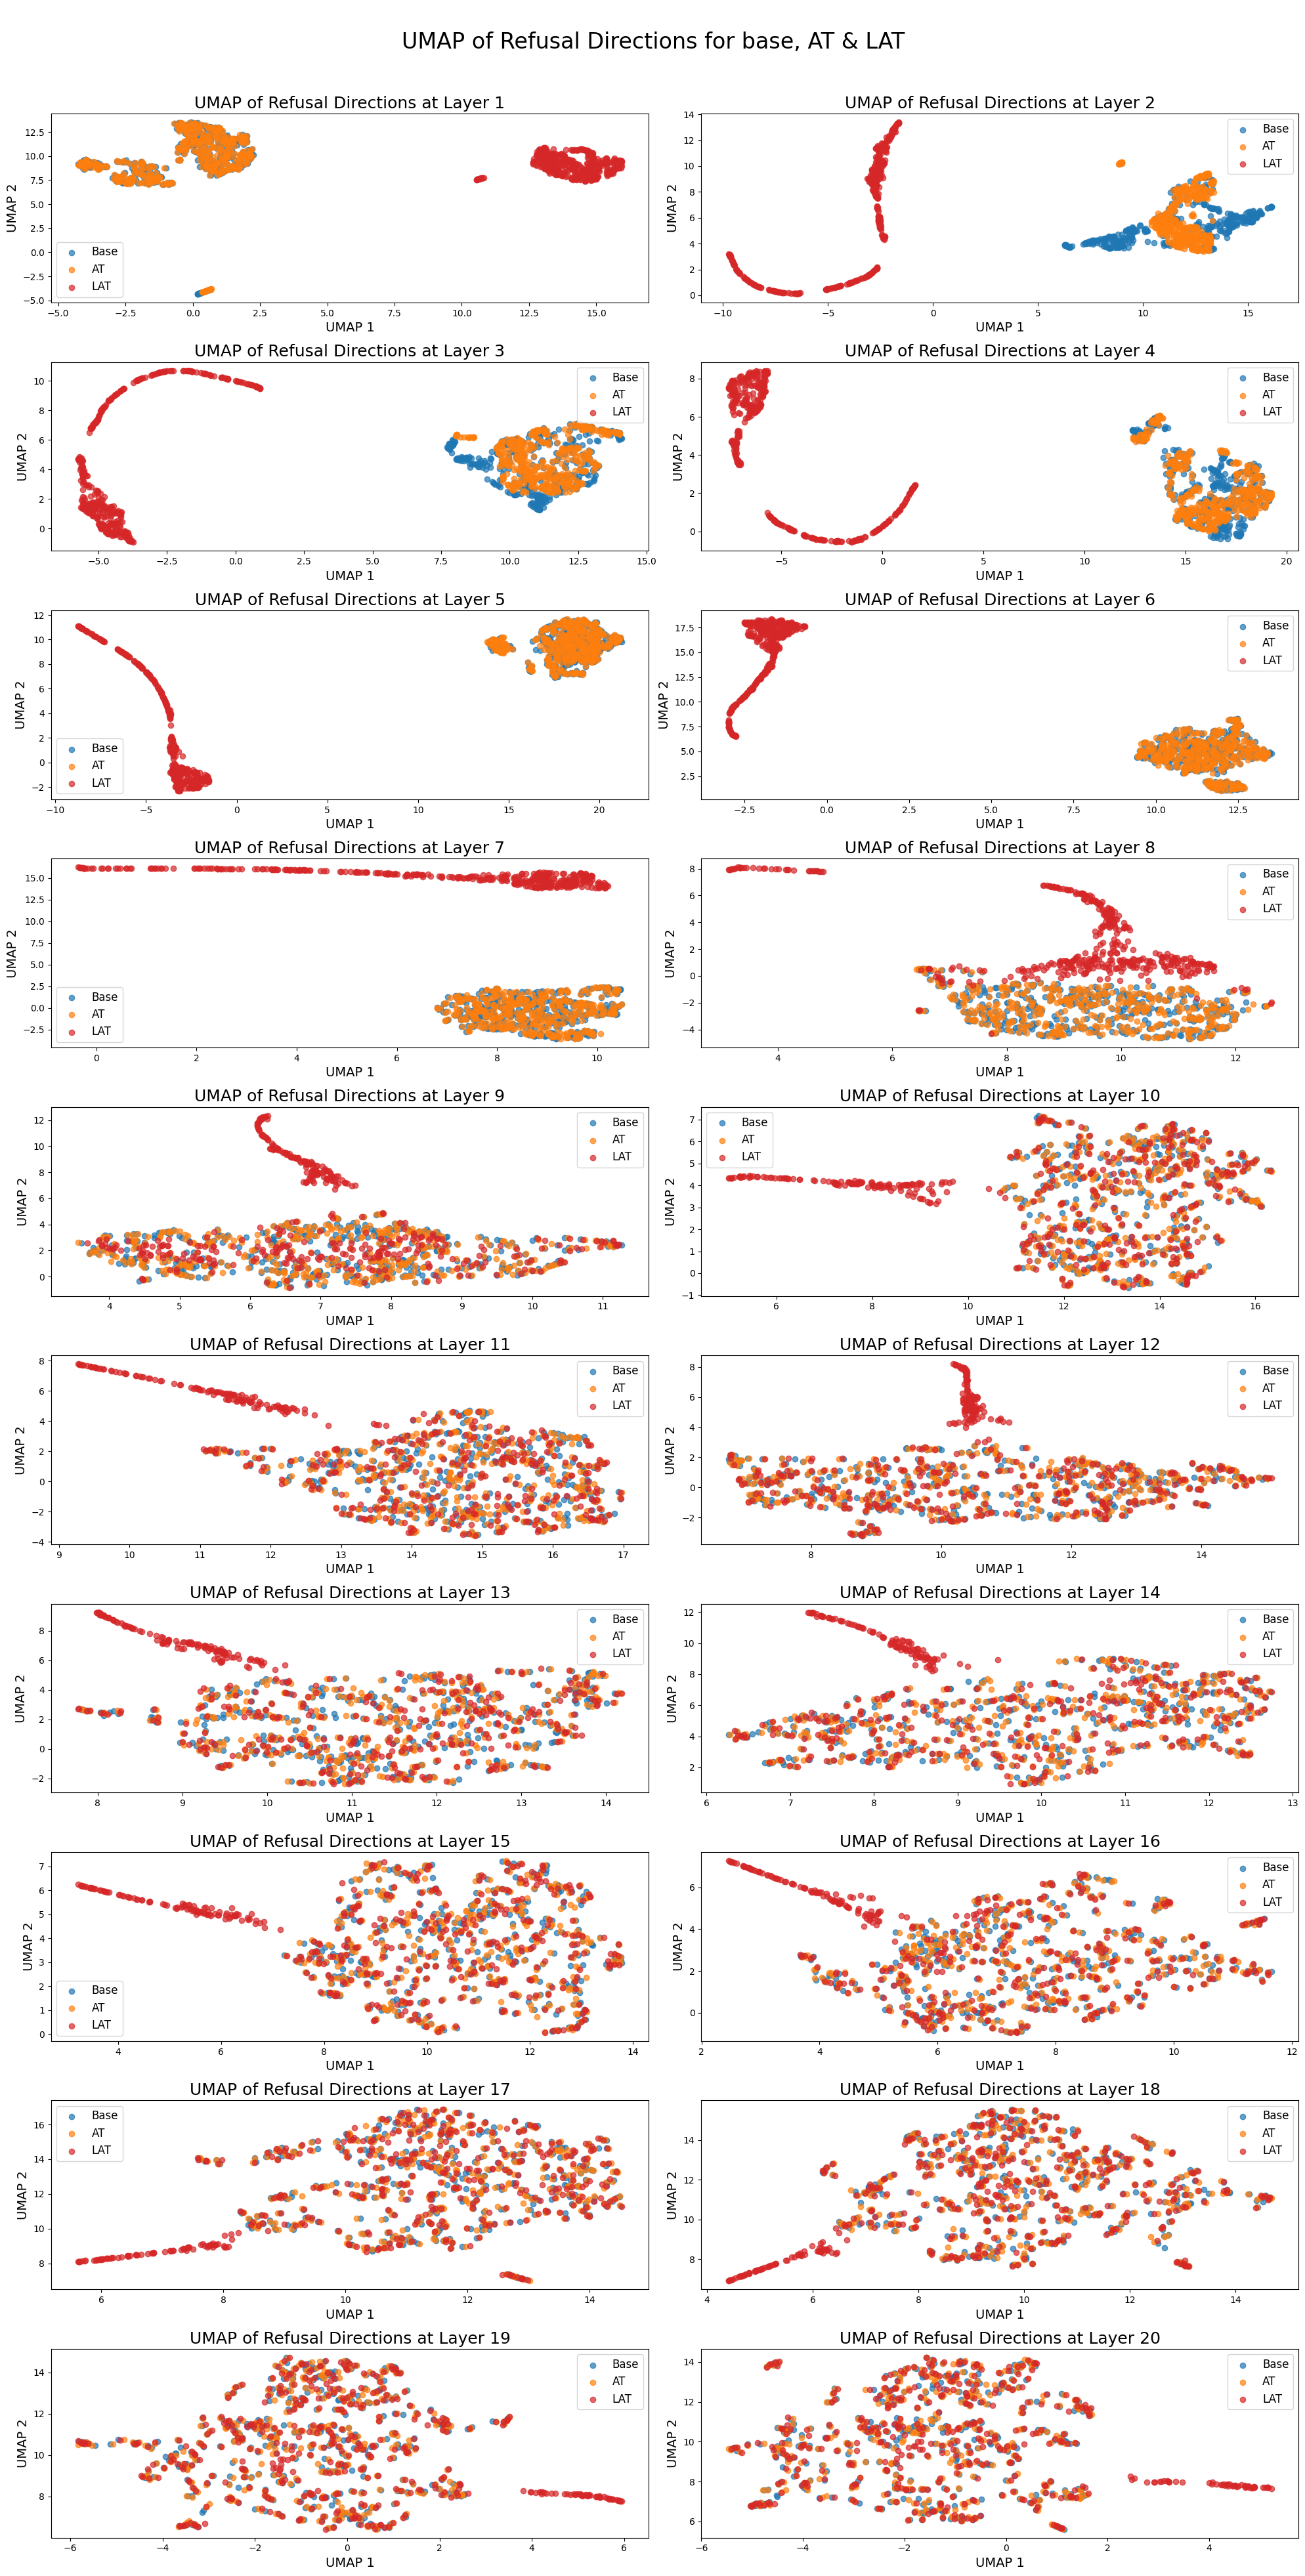

In [198]:
visualize_refusal_directions_combined_multi_technique(base_results, at_results, lat_results, range(1, 21), technique='umap')

### Refusal dir change with num examples

In [39]:
def create_refusal_vector(harmful_acts: np.ndarray, harmless_acts: np.ndarray) -> np.ndarray:
    harmful_mean_act = harmful_acts.mean(axis=0)
    harmless_mean_act = harmless_acts.mean(axis=0)
    refusal_dir = harmful_mean_act - harmless_mean_act
    return refusal_dir / np.linalg.norm(refusal_dir)

def analyze_convergence(harmful_acts: np.ndarray, harmless_acts: np.ndarray, 
                        max_samples: int = 400, step: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    distances = []
    sample_sizes = range(1, max_samples + 1, step)
    prev_vector = None
    
    for n in sample_sizes:
        harmful_sample = harmful_acts[:n]
        harmless_sample = harmless_acts[:n]
        current_vector = create_refusal_vector(harmful_sample, harmless_sample)
        
        if prev_vector is not None:
            distance = np.linalg.norm(current_vector - prev_vector)
            distances.append(distance)
        
        prev_vector = current_vector
    
    return np.array(distances)

def plot_convergence(sample_sizes: np.ndarray, base_dists, at_dists, lat_dists):
    plt.figure(figsize=(10, 6))

    plt.plot(sample_sizes, base_dists, label='Base')
    plt.plot(sample_sizes, at_dists, label='AT')
    plt.plot(sample_sizes, lat_dists, label='LAT')

    plt.xticks(range(0, 401, 25))
    plt.title('Refusal Vector Convergence')
    plt.xlabel('Number of Samples')
    plt.ylabel('Euclidean Distance Between Adjacent Vectors')
    plt.legend()
    plt.xscale('log')
    plt.grid(True)
    plt.show()

def find_optimal_samples(sample_sizes: np.ndarray, distances: np.ndarray, threshold: float = 0.01) -> int:
    for i, distance in enumerate(distances):
        if distance < threshold:
            return sample_sizes[i]
    return sample_sizes[-1]

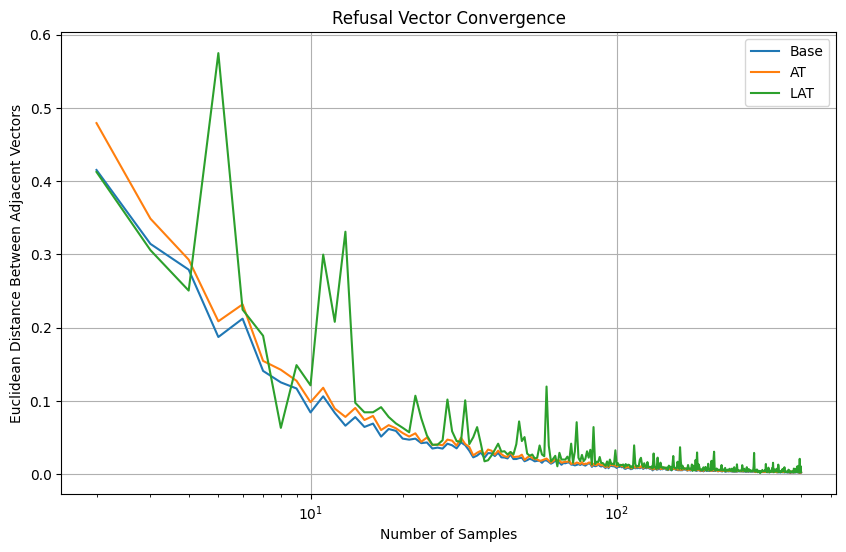

Optimal number of samples (base): 92
Optimal number of samples (AT): 92
Optimal number of samples (LAT): 106


In [40]:
sample_sizes = list(range(1, 400 + 1, 1))[1:]
base_distances = analyze_convergence(base_harmful_acts, base_harmless_acts)
at_distances = analyze_convergence(at_harmful_acts, at_harmless_acts)
lat_distances = analyze_convergence(lat_harmful_acts, lat_harmless_acts)

plot_convergence(sample_sizes, base_distances, at_distances, lat_distances)

optimal_samples = find_optimal_samples(sample_sizes, base_distances)
print(f"Optimal number of samples (base): {optimal_samples}")

optimal_samples = find_optimal_samples(sample_sizes, at_distances)
print(f"Optimal number of samples (AT): {optimal_samples}")

optimal_samples = find_optimal_samples(sample_sizes, lat_distances)
print(f"Optimal number of samples (LAT): {optimal_samples}")

In [31]:
# plot_convergence(sample_sizes, distances)